# DA 231o Data Engineering at Scale Project



# Expected Goals Model & Player Analysis

### Import Libraries

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 55.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d3d38cc4881b83a688ad907718f7cb792a39f96eee27a72fd4c37e5034b68e91
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import pyspark
pyspark.__version__

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_replace, when, col

# Load input Dataset with Goals

In [3]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Read the csv file for visualization. We do not use this data anywhere in our model

data = pd.read_csv('/content/drive/Shareddrives/DES_Project/events.csv')

In [8]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

941009
24446
21


In [9]:
data.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

In [10]:
# Create spark session

spark = SparkSession \
    .builder \
    .appName('xG Project Solution') \
    .getOrCreate()
  
spark

In [11]:
# Load the events and the info as spark sql dataframes

eventsDF = spark.read.option("header", True).option("inferSchema", True).option("nullable", 'NA').csv('/content/drive/Shareddrives/DES_Project/events.csv')
infoDF = spark.read.option("header", True).option("inferSchema", True).option("nullable", 'NA').csv('/content/drive/Shareddrives/DES_Project/ginf.csv')

In [12]:
# Print Schema

eventsDF.printSchema()

infoDF.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: string (nullable = true)
 |-- shot_outcome: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: string (nullable = true)
 |-- fast_break: integer (nullable = true)

root
 |-- id_odsp: string (nullable = true)
 |-- link_odsp: string (nullable = true)
 |-- adv_stat

In [13]:
# Verify if the data loaded is correct and in the proper format

eventsDF.show(10)
type(eventsDF)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hamburg SV|Borussia Dortmund|      mladen petric|     gokhan tore|       NA|        NA|         6|       

pyspark.sql.dataframe.DataFrame

In [14]:
# Join id_odsp, country, date columns from infoDF on id_odsp

eventsDF = eventsDF.join(infoDF[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
eventsDF.printSchema()
eventsDF.show(10)
eventsDF.count()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: string (nullable = true)
 |-- shot_outcome: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: string (nullable = true)
 |-- fast_break: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- date: timestamp (nullable = true)

+---------+---------

941009

In [15]:
# Extract year from the timestamp and append the column

extract_year = lambda x: x.strftime("%Y")
extract_year_udf = udf(extract_year)
eventsDF = eventsDF.withColumn("year", extract_year_udf("date"))
eventsDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hambur

In [16]:
eventsDF.filter(eventsDF.event_type==1).filter(eventsDF.player != '').count()

229134

In [17]:
# Create shotsDF dataframe by filtering event type == 1 and non-empty player

shotsDF = eventsDF.filter(eventsDF.event_type==1).filter(eventsDF.player != '').filter(eventsDF.player2 != '').filter(eventsDF.country != '')
shotsDF = shotsDF.withColumn("player", udf(lambda x: x.title())("player"))
shotsDF = shotsDF.withColumn("player2", udf(lambda x: x.title())("player2"))
shotsDF = shotsDF.withColumn("country", udf(lambda x: x.title())("country"))
shotsDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hambur

In [18]:
# Filter the columns which have all the relevant information about the shot and predict if it is a goal or not
# is_goal is the true label. We will not use this in the training

required_cols = ['shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation']

# Create dataDF dataframe with all the input columns
dataDF = shotsDF

# Create string indexer list
indexer = []

# Convert each column into integer type using string indexer without losing any features
for column in required_cols:
  temp = StringIndexer(inputCol=column, outputCol=column+"_index")
  indexer.append(temp)

# Pipeline
pipeline = Pipeline(stages=indexer)
dataDF = pipeline.fit(dataDF).transform(dataDF)

dataDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+----

# Expected Goals with PySpark Machine Learning

In [19]:
required_features = list(dataDF.columns[-6:]) # remove 'is_goal' because it is the label

assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(dataDF)

transformed_data.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+-------------

In [20]:
# Split the data into training and testing data

(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

print("Total Data", transformed_data.count())
print("Total Training Data", training_data.count())
print("Total Test Data", test_data.count())

print("\nTraining Dataset")
training_data.show(5)

Total Data 229131
Total Training Data 183117
Total Test Data 46014

Training Dataset
+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--------+------------------+---------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+
|  id_odsp|   id_event|sort_order|time|                text|event_type|event_type2|side|event_team|opponent|            player|        player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|
+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+----

# Gradient-Boosted Trees (GBTs) Classifier

In [21]:
gbt = GBTClassifier(labelCol='is_goal', 
                            featuresCol='features',
                            maxDepth=5)

In [22]:
# Another classifier
# from pyspark.ml.classification import DecisionTreeClassifier
# gbt = DecisionTreeClassifier(labelCol='is_goal', 
#                             featuresCol='features',
#                             maxDepth=5)

In [23]:
# Fit the model on training data
model = gbt.fit(training_data)

# Predictions with Test Data

In [24]:
# Predictions with test data
predictions = model.transform(test_data)
predictions.show(5)

+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--------+------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+
|  id_odsp|   id_event|sort_order|time|                text|event_type|event_type2|side|event_team|opponent|            player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|       rawPrediction|         probability|prediction|
+---------+-----------+----------+----+--------------------+----------+---------

# Evaluate our model

In [25]:
# Evaluate our model
evaluator = MulticlassClassificationEvaluator(
    labelCol='is_goal', 
    predictionCol='prediction', 
    metricName='accuracy')

# Calculate Test Accuracy

In [26]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.9382144564697701


In [27]:
from pyspark.ml.evaluation import RegressionEvaluator

regEvaluator = RegressionEvaluator(
    labelCol='is_goal', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = regEvaluator.evaluate(predictions)
print('RMSE = ', rmse)

RMSE =  0.24856697996763355


# Player Analysis

In [106]:
def do_player_analysis(model, dataset, player_names=None):
  pred = model.transform(dataset)
  # pred.show()
  players = pred.select('player', 'is_goal', 'prediction')
  # Count the number of actual goals and expected goals per player

  metrics = players.groupBy('player').sum()
  metrics = metrics.withColumnRenamed('sum(is_goal)', 'true_goals').withColumnRenamed('sum(prediction)', 'expected_goals')

  # Calculate the difference between the expected goals and the true goals
  # Absolute difference indicates the number of goals made on top of the expected goals
  metrics = metrics.withColumn('difference', metrics.expected_goals - metrics.true_goals)

  # Sort by the least difference (Expected - True)
  result = metrics.sort('difference')

  # Best Finishers with most goals on top of expected
  # Top 10 finishers
  # result.show(10)

  # Messi is my favourite player. So showing the result below
  # result.filter(result.player == 'Lionel Messi').show()

  # Sort by ratio between the true goals and the expected goals in descending order
  # Best Finishers with highest (true goals / expected goals) ratio
  result = result.withColumn('ratio', result['true_goals'] / result['expected_goals'])
  # result.orderBy(col('ratio').desc()).show(5)

  cor = result.stat.corr('true_goals', 'expected_goals')
  print("Correlation between Expected Goals and True Goals is", cor)

  if player_names is None:
    result = result.limit(10)
  else:
    result = result.filter(result.player.isin(player_names))
  # graphDF.head(10)
  graphDF = result.toPandas()[['player', 'difference', 'true_goals', 'expected_goals', 'ratio']]

  fig, ax = plt.subplots(figsize=[12,5])
  ax = sns.barplot(x=abs(graphDF['difference']), y=graphDF['player'])
  # ax.set_xticks(np.arange(0,65,5))
  ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
  ax.set_ylabel(ylabel='')
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
  plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
  ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
  plt.show()

  graphDF = graphDF.sort_values(['ratio', 'true_goals'], ascending=False).reset_index(drop=True)
  graphDF = graphDF.sort_values(['ratio', 'true_goals'], ascending=False).reset_index(drop=True)
  graphDF = graphDF[['player', 'ratio', 'true_goals', 'expected_goals', 'difference']].head(10)
  # graphDF.head(10)

  fig, ax = plt.subplots(figsize=[12,5])
  ax = sns.barplot(x=graphDF['ratio'], y=graphDF['player'])
  # ax.set_xticks(np.arange(0,1.9,0.2))
  ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
  ax.set_ylabel(ylabel='')
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
  plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
  ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
  plt.show()

Correlation between Expected Goals and True Goals is 0.9831872012016246


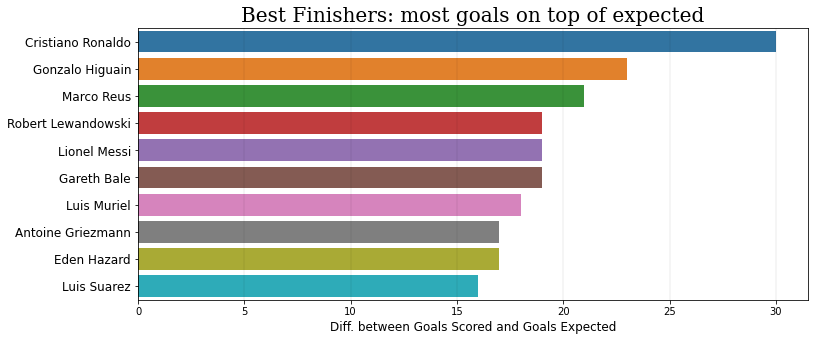

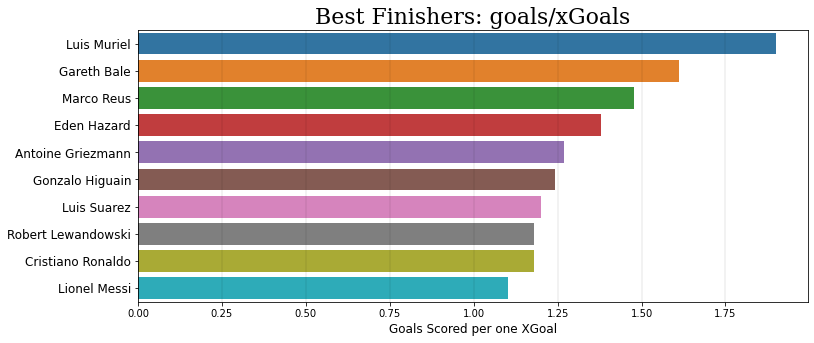

In [107]:
do_player_analysis(model, transformed_data)

In [108]:
test_data_len = test_data.count()
live_data_20 = training_data.union(test_data.limit(int(test_data_len*0.2)))
live_data_40 = training_data.union(test_data.limit(int(test_data_len*0.4)))
live_data_60 = training_data.union(test_data.limit(int(test_data_len*0.6)))
live_data_80 = training_data.union(test_data.limit(int(test_data_len*0.8)))
live_data_100 = training_data.union(test_data.limit(int(test_data_len*1.0)))

Correlation between Expected Goals and True Goals is 0.9807486037683344


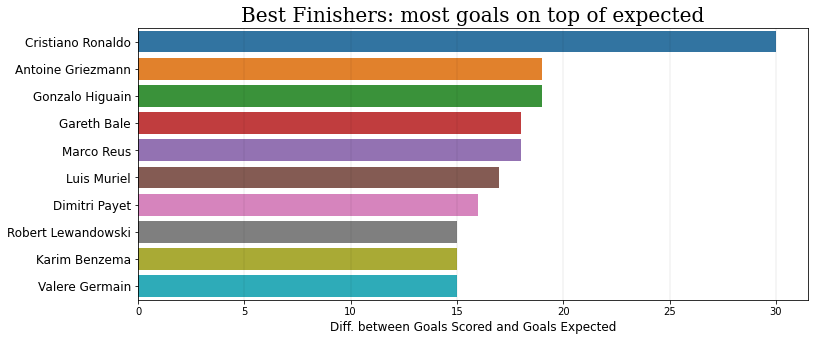

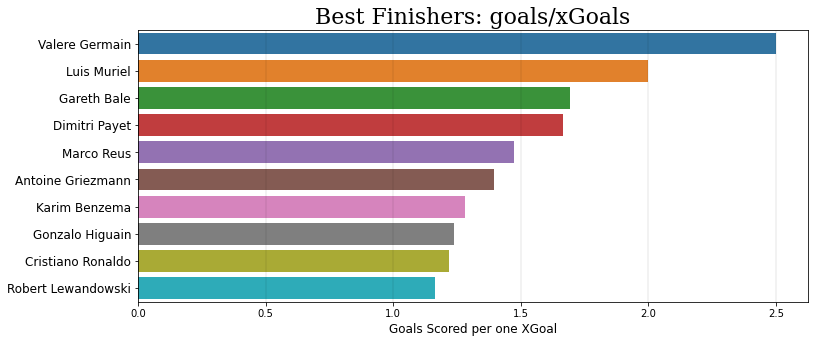

In [111]:
do_player_analysis(model, live_data_20) # player_names=['Lionel Messi']

Correlation between Expected Goals and True Goals is 0.9812082330972153


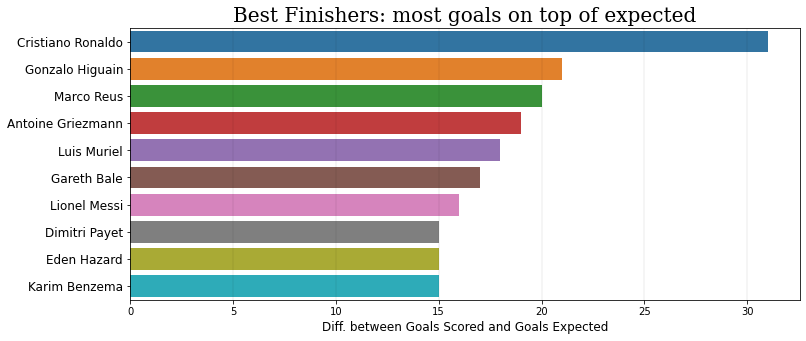

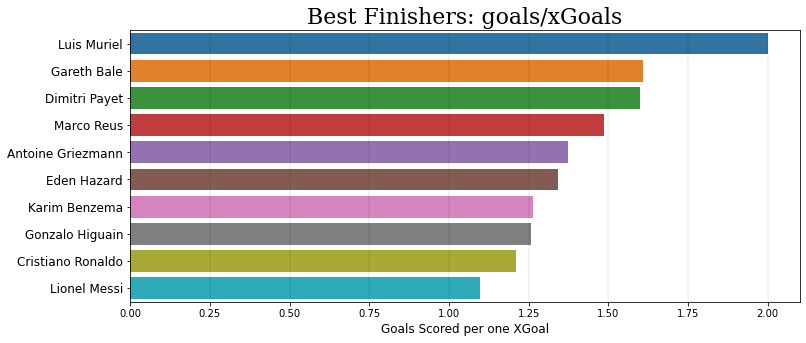

In [112]:
do_player_analysis(model, live_data_40)

Correlation between Expected Goals and True Goals is 0.9814040322904556


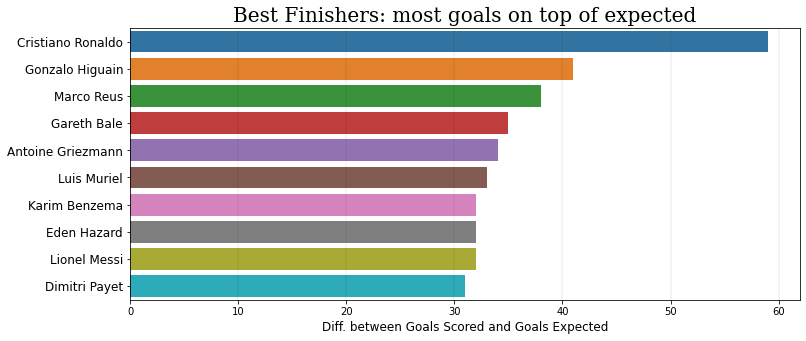

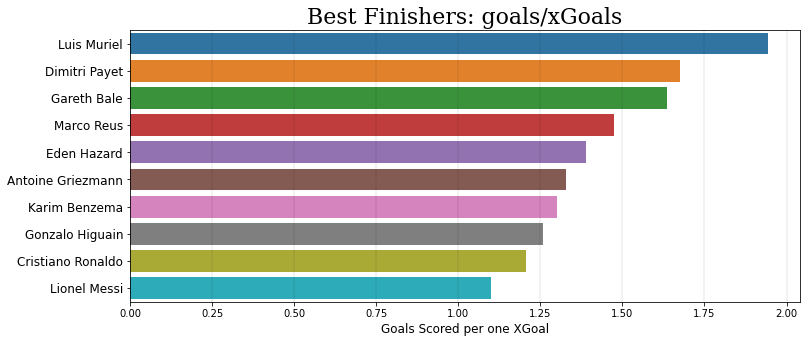

In [66]:
do_player_analysis(model, live_data_60)

Correlation between Expected Goals and True Goals is 0.9826429745820308


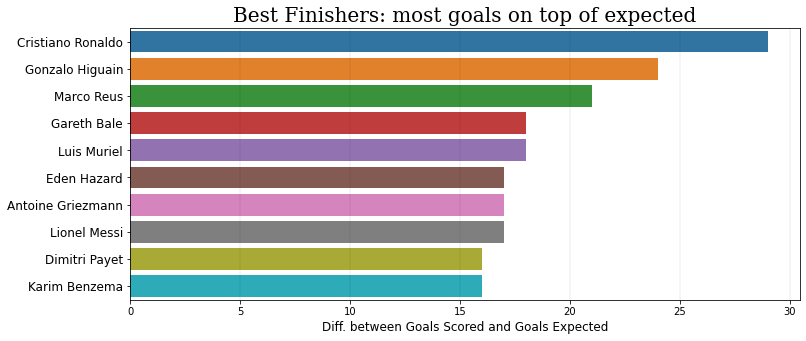

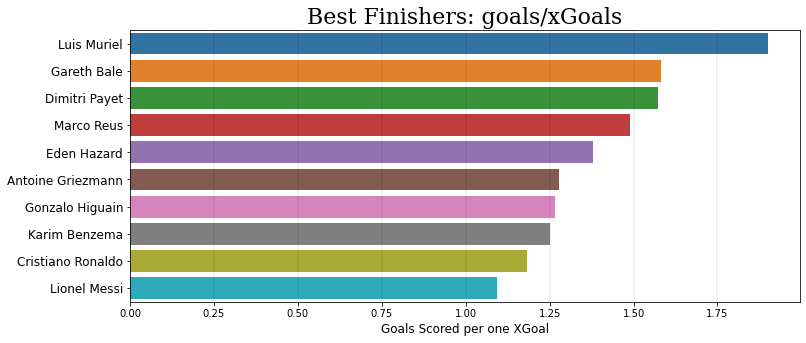

In [67]:
do_player_analysis(model, live_data_80)

Correlation between Expected Goals and True Goals is 0.9831872012016271


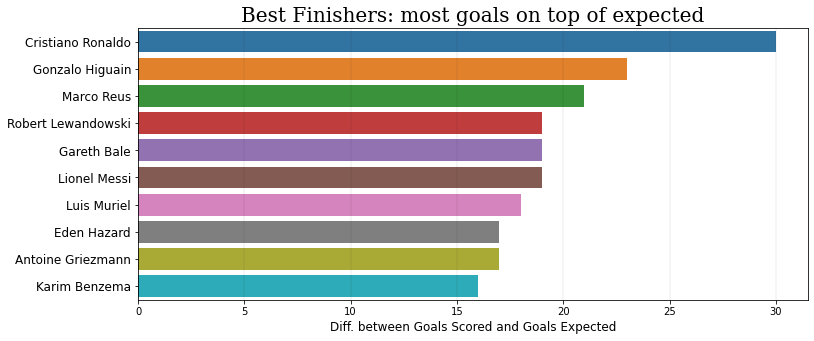

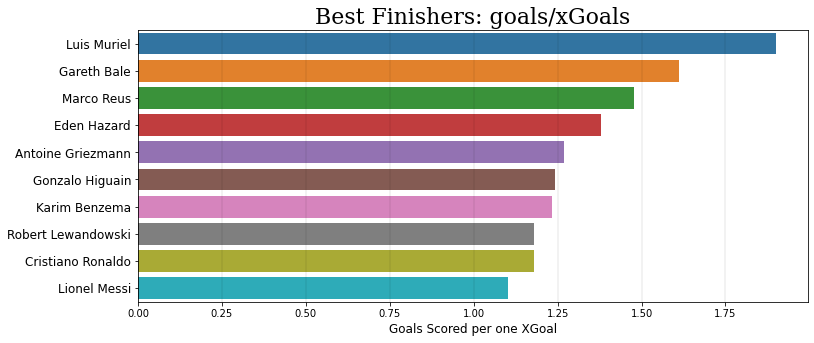

In [68]:
do_player_analysis(model, live_data_100)